## Classifying Exoplanets: Exploring NASA's Kepler Space Observatory Dataset

## Introduction

One of the most fascinating subjects in astronomical research is finding exoplanets, planets that orbit stars beyond our solar system. The Kepler Space Observatory, a NASA space telescope for finding exoplanets, has analyzed thousands of planets, especially ones that are roughly Earth-sized and within habitable zones. From 2009 to 2018, Kepler revolutionized our understanding of extrasolar systems by cross-checking previous observations of exoplanets and labeling them as confirmed planets, candidates, or false positives.
Our primary question is: *Can we accurately classify celestial bodies as exoplanets based on their observed characteristics using the Kepler exoplanet dataset?*
Our project will analyze the NASA Kepler exoplanet dataset. This dataset contains details about celestial objects, including their radius, transit, stellar luminosity, and other essential attributes. By analyzing this dataset, we hope to develop a predictive classification model that discerns exoplanets from other extrasolar entities.

In [1]:
install.packages("GGally")

also installing the dependencies ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Warning message in install.packages("GGally"):
“installation of package ‘broom.helpers’ had non-zero exit status”
Warning message in install.packages("GGally"):
“installation of package ‘ggstats’ had non-zero exit status”
Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
install.packages("recipes")
install.packages("kknn")

also installing the dependency ‘hardhat’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
library(tidyverse)
library(tidymodels)
library(GGally)
library(repr)
library(recipes)
library(kknn)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in library(GGally): there is no package called ‘GGally’


## Loading Original Data

In [4]:
## Reading the original data from Kaggle
exoplanet <- read_csv("https://raw.githubusercontent.com/QuwackJ/dsci-100-group-37/main/Data/cumulative.csv")
cat("\n↓ Table 1. First 6 rows of the Exoplanet dataset ↓\n")
head(exoplanet)

Rows: 9564 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): kepoi_name, kepler_name, koi_disposition, koi_pdisposition, koi_tc...
dbl (43): rowid, kepid, koi_score, koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_...
lgl  (2): koi_teq_err1, koi_teq_err2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



↓ Table 1. First 6 rows of the Exoplanet dataset ↓


rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,⋯,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,⋯,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.9342,48.14165,15.347
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,⋯,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.9342,48.14165,15.347
3,10811496,K00753.01,NA,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,⋯,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.0048,48.13413,15.436
4,10848459,K00754.01,NA,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,⋯,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.5346,48.28521,15.597
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,⋯,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.7549,48.22620,15.509
6,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,⋯,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.2861,48.22467,15.714


## Wrangling Original Data

In [5]:
## Counting NA values in original data
na_in_exoplanet <- exoplanet |>
                   summarize_all(~ sum(is.na(.)))
cat("\n↓ Table 2. NA values in the Exoplanet dataset ↓\n")
na_in_exoplanet

## Selecting for our predictors and removing planets with less confidence
exoplanet_selected <- exoplanet |>
                        mutate(koi_disposition = as_factor(koi_disposition)) |>
                        mutate(koi_disposition = fct_recode(koi_disposition, "NOT EXOPLANET" = "FALSE POSITIVE")) |>
                        filter((koi_disposition == "NOT EXOPLANET" & koi_score <= 0.3) | (koi_disposition == "CONFIRMED" & koi_score >= 0.8)) |>
                        select(koi_disposition, koi_score, koi_period, koi_depth, koi_duration, koi_impact)
cat("\n↓ Table 3. First 6 rows of the selected Exoplanet dataset ↓\n")
head(exoplanet_selected)

disposition_count <- exoplanet_selected |>
                     group_by(koi_disposition) |>
                     summarize(count = n())
cat("\n↓ Table 4. Counts for the categorical variable ↓\n")
disposition_count

## Counting the number of rows in the selected data
row_count_exoplanet_selected <- count(exoplanet_selected)
cat("\n↓ Table 5. Counts of rows in the selected Exoplanet dataset ↓\n")
row_count_exoplanet_selected

## Counting NA values in selected data
na_in_exoplanet_selected <- exoplanet_selected |>
                            summarize_all(~ sum(is.na(.)))
cat("\n↓ Table 6. NA values in the selected Exoplanet dataset ↓\n")
na_in_exoplanet_selected

## Removing NA values in exoplanet_selected
exoplanet_selected <- exoplanet_selected |>
                      drop_na()  
cat("\n↓ Table 7. First 6 rows of the selected Exoplanet dataset without NA values ↓\n")
head(exoplanet_selected)

## Splitting into training and testing data
exoplanet_split <- initial_split(exoplanet_selected, prop = 0.75, strata = koi_disposition)
training_data <- training(exoplanet_split)   
testing_data <- testing(exoplanet_split)


↓ Table 2. NA values in the Exoplanet dataset ↓


rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,⋯,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,7270,0,0,1510,0,0,0,⋯,483,363,468,468,363,468,468,0,0,1



↓ Table 3. First 6 rows of the selected Exoplanet dataset ↓


koi_disposition,koi_score,koi_period,koi_depth,koi_duration,koi_impact
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CONFIRMED,1.000,9.488036,615.8,2.95750,0.146
CONFIRMED,0.969,54.418383,874.8,4.50700,0.586
NOT EXOPLANET,0.000,19.899140,10829.0,1.78220,0.969
NOT EXOPLANET,0.000,1.736952,8079.2,2.40641,1.276
CONFIRMED,1.000,2.525592,603.3,1.65450,0.701
CONFIRMED,1.000,11.094321,1517.5,4.59450,0.538



↓ Table 4. Counts for the categorical variable ↓


koi_disposition,count
<fct>,<int>
CONFIRMED,2183
NOT EXOPLANET,3916



↓ Table 5. Counts of rows in the selected Exoplanet dataset ↓


n
<int>
6099



↓ Table 6. NA values in the selected Exoplanet dataset ↓


koi_disposition,koi_score,koi_period,koi_depth,koi_duration,koi_impact
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,54,0,54



↓ Table 7. First 6 rows of the selected Exoplanet dataset without NA values ↓


koi_disposition,koi_score,koi_period,koi_depth,koi_duration,koi_impact
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CONFIRMED,1.000,9.488036,615.8,2.95750,0.146
CONFIRMED,0.969,54.418383,874.8,4.50700,0.586
NOT EXOPLANET,0.000,19.899140,10829.0,1.78220,0.969
NOT EXOPLANET,0.000,1.736952,8079.2,2.40641,1.276
CONFIRMED,1.000,2.525592,603.3,1.65450,0.701
CONFIRMED,1.000,11.094321,1517.5,4.59450,0.538


## Classification

! Fold1: internal:
  There were 15 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'CA...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 14 ...

! Fold2: internal:
  There were 15 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'CA...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 14 ...

! Fold3: internal:
  There were 15 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'C

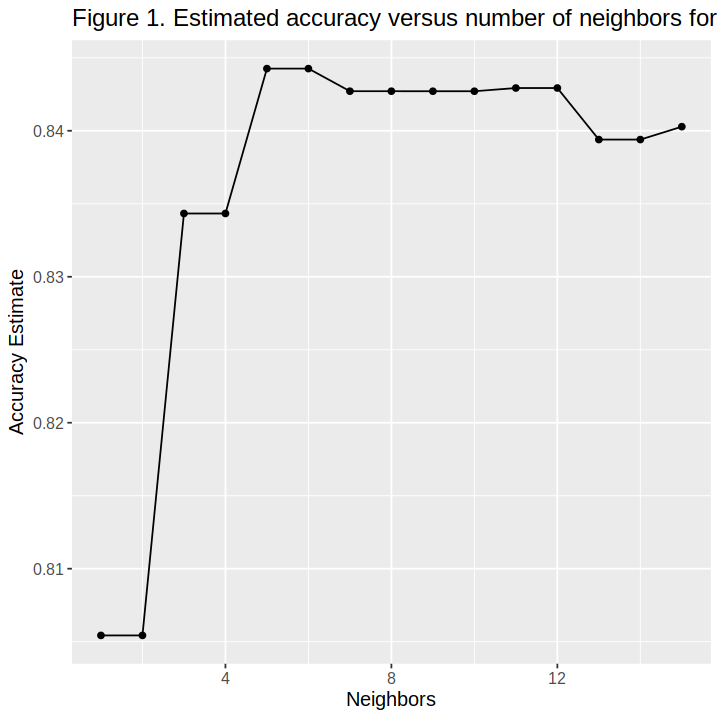

In [17]:
set.seed(1234) 

options(repr.plot.height = 6, repr.plot.width = 6)

recipe <- recipe(koi_disposition ~ ., data = training_data) |>
          step_rm(koi_score) |>
          step_scale(all_predictors()) |>
          step_center(all_predictors())  

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
           set_engine("kknn") |>
           set_mode("classification")

vfold <- vfold_cv(training_data, v = 5, strata = koi_disposition)

k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

knn_fit <- workflow() |>
          add_recipe(recipe) |>
          add_model(knn_tune) |>
          tune_grid(resamples = vfold, grid = k_vals) |>
          collect_metrics()
      
accuracies <- knn_fit |> 
            filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate") + 
                  ggtitle("Figure 1. Estimated accuracy versus number of neighbors for the training data") +
                  theme(text = element_text(size = 12))

cross_val_plot

In [20]:
exo_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6)|>
          set_engine("kknn") |>
          set_mode("classification")

exo_fit <- workflow() |>
          add_recipe(recipe) |>
          add_model(exo_spec) |>
          fit(data = training_data)

final_prediction <- predict(exo_fit, testing_data)|>
                    bind_cols(testing_data)

final_prediction_accuracy <- final_prediction |>
                            metrics(truth=koi_disposition,estimate=.pred_class)
cat("\n↓ Table 8. Accuracies of predicting the testing data ↓\n")

final_prediction_accuracy


↓ Table 8. Accuracies of predicting the testing data ↓


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8538360
kap,multiclass,0.6885618


**Classification analysis**

After we observed relationships between our chosen predictors, we tried to solve the predictive question of accurately classifying celestial bodies as exoplanets based on the predictors selected from the Kepler exoplanet dataset.

We used the K-Nearest Neighbors (KNN) algorithm for this classification analysis, with the dataset split into 75% training data and 25% testing data. This step is essential for assessing the performance and generalization capabilities of the KNN model. It allows for an unbiased evaluation and helps prevent overfitting, which is critical for developing reliable machine-learning models. Next, we created a model recipe and a specification for the training data and implemented 5-fold cross-validation to optimize the hyperparameter K. We tuned the KNN classifier with these predictors and collected the accuracy for the best K. By creating a plot with estimated accuracy versus the number of neighbors from 1 to 15, we found the best K value to be 5 or 6 (Fig. 1). The plot shows the accuracy estimates increase with K value from 1 to 6, followed by a slight decrease. Since the dataset is relatively large as shown in Table 9, choosing a large K value has its advantages, such as lower variance to avoid overfitting and reduced sensitivity to noise. However, it also introduces drawbacks, including potential loss of local detail and increased bias. The optimal K value depends on the specific characteristics of the dataset and the balance between bias and variance that is suitable for the given problem. 

According to the accuracy plot, we picked K = 10 for the KNN classifier model of the testing data. We used the metrics function to assess the model's performance, with the final accuracy achieved as 0.8538360, and the Kappa (kap) statistic was 0.6885618 (Table 8). The accuracy of 85.38% suggests that our classification model is performing well. This metric represents the proportion of correctly classified instances among the total instances in the testing set. In the context of our predictive question, this high accuracy indicates that the observed characteristics in the Kepler exoplanet dataset are informative and discriminatory enough to distinguish between exoplanets and other celestial bodies. The Kappa statistic measures the agreement between the predicted and actual classifications while accounting for the possibility of agreement occurring by chance. A Kappa value of 0.6885618 suggests substantial agreement beyond what would be expected by random chance. In the context of our analysis, this indicates that our classification model is accurate and robust, as it considers the possibility of random agreement and still demonstrates significant predictive power.

## Predictor Correlation Plot

In [21]:
options(repr.plot.width = 11, repr.plot.height = 11)
predictor_plot <- ggpairs(exoplanet_selected, columns = 2:5, 
                          ggplot2::aes(colour = koi_disposition), 
                          upper = list(continuous = wrap("cor", size = 4)), 
                          lower = list(continuous = wrap("points", alpha = 0.6)))
predictor_plot + theme(axis.text = element_text(size = 12), 
                       strip.text.x = element_text(size = 15), 
                       strip.text.y = element_text(size = 15)) +
                       ggtitle("Figure 2. Correlation between all the predictors in the selected Exoplanet dataset")

ERROR: Error in ggpairs(exoplanet_selected, columns = 2:5, ggplot2::aes(colour = koi_disposition), : could not find function "ggpairs"


In [22]:
#Summary Tables:-




##Count the number of confirmed and not exoplanet



disposition_count <- exoplanet_selected |>
                     group_by(koi_disposition) |>
                     summarize(count = n())

cat("\n↓ Table 9. Disposition Count ↓\n")

disposition_count



##Mean and SD for predictor values for confirmed


exoplanet_filter_confirmed_mean <- exoplanet_selected |>
                                filter(koi_disposition == "CONFIRMED") |>
                                select(-koi_disposition, -koi_score) |>
                                map_df(mean, na.rm = TRUE)


exoplanet_filter_confirmed_sd <- exoplanet_selected |>
                                filter(koi_disposition == "CONFIRMED") |>
                                select(-koi_disposition, -koi_score) |>
                                map_df(sd, na.rm = TRUE)



cat("\n↓ Table 10. Means of all predictors for CONFIRMED exoplanets ↓\n")

exoplanet_filter_confirmed_mean

cat("\n↓ Table 11. Standard deviation of all predictors for CONFIRMED exoplanets ↓\n")

exoplanet_filter_confirmed_sd
##Mean and SD for predictor values for not exoplanet


exoplanet_filter_not_exoplanet_mean <- exoplanet_selected |>
                                filter(koi_disposition == "NOT EXOPLANET") |>
                                select(-koi_disposition, -koi_score) |>
                                map_df(mean, na.rm = TRUE)



exoplanet_filter_not_exoplanet_sd <- exoplanet_selected |>
                                filter(koi_disposition == "NOT EXOPLANET") |>
                                select(-koi_disposition, -koi_score) |>
                                map_df(sd, na.rm = TRUE)

cat("\n↓ Table 12. Means of all predictors for NOT EXOPLANETS ↓\n")

exoplanet_filter_not_exoplanet_mean

cat("\n↓ Table 13. Standard deviation of all predictors for NOT EXOPLANETS ↓\n")

exoplanet_filter_not_exoplanet_sd


↓ Table 9. Disposition Count ↓


koi_disposition,count
<fct>,<int>
CONFIRMED,2183
NOT EXOPLANET,3862



↓ Table 10. Means of all predictors for CONFIRMED exoplanets ↓


koi_period,koi_depth,koi_duration,koi_impact
<dbl>,<dbl>,<dbl>,<dbl>
24.86312,1096.265,4.233625,0.4253344



↓ Table 11. Standard deviation of all predictors for CONFIRMED exoplanets ↓


koi_period,koi_depth,koi_duration,koi_impact
<dbl>,<dbl>,<dbl>,<dbl>
42.64761,2581.022,2.603013,0.3313387



↓ Table 12. Means of all predictors for NOT EXOPLANETS ↓


koi_period,koi_depth,koi_duration,koi_impact
<dbl>,<dbl>,<dbl>,<dbl>
39.87195,53463.21,6.420553,0.7935036



↓ Table 13. Standard deviation of all predictors for NOT EXOPLANETS ↓


koi_period,koi_depth,koi_duration,koi_impact
<dbl>,<dbl>,<dbl>,<dbl>
101.0794,116145.5,8.28621,1.006435


## References

Dataset: https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results

Column Explanation: https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
